Protected Lands 
===

This notebook merges FieldDoc protected lands with WeConservePA protected lands and plots the distribution of protection type in each cluster and subbasin.

FieldDoc protected lands are lands who's protection has been supported, either directly (OSI programs) or indirectly (Delaware Watershed Operational Fund), by the William Penn Foundation. This data was obtained from FieldDoc on 8/11/2022.

WeConservePA protected lands combines multiple protected lands datasets from across states into a singular dataset for protected lands within the Delware River Basin. The 2022 WeConservePA protected lands data containing protected lands, clusters, land trust associations, and watershed associations within the Delaware River Basin. This data was obtained from Pennsylvania Spatial Data Access (PASDA): https://www.pasda.psu.edu/uci/DataSummary.aspx?dataset=1905

# Setup

## Imports

In [58]:
# Import packages
from pathlib import Path
import math
import numpy as np
import pandas as pd
import geopandas as gpd

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from shapely.validation import make_valid
import contextily as ctx
from IPython.display import clear_output

In [2]:
import warnings

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

## File paths

In [4]:
# Find your current working directory, which should be folder for this notebook.
Path.cwd()

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment/stage2/Protected_Lands')

In [5]:
# Set your project directory to your local folder for your clone of this repository
project_path = Path.cwd().parent.parent
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [6]:
# Path to WeConservePA protected lands shapefile
wcpa_path = project_path / Path('stage2/Protected_Lands/WeConservePA_Shapefile/WeConservePA_pl_20220810.shp')
wcpa_path.exists()

True

## Private file paths
- Download from https://drive.google.com/drive/folders/1HKlnA3lC2xvKBQ1bg1J08gsEB3N9rp2V
- Save in `stage2/private` folder

In [7]:
# Path to FieldDoc protected lands export file
fielddoc_path = project_path / Path('stage2/private/protection_bmps_from_FieldDoc.parquet')
fielddoc_path.exists()

True

# Load data

## Protected Lands from WeConservePA

In [8]:
# Import weconservePA protected lands
wcpa_gdf = gpd.read_file(wcpa_path)

wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    22137 non-null  int64   
 1   Category    22137 non-null  object  
 2   sitename    21956 non-null  object  
 3   esmthldr    8877 non-null   object  
 4   eholdtype   8868 non-null   object  
 5   own_name    13258 non-null  object  
 6   own_type    18637 non-null  object  
 7   URL         20702 non-null  object  
 8   purpose     18507 non-null  object  
 9   year_est    22137 non-null  int64   
 10  gis_acres   22137 non-null  float64 
 11  pubaccess   22015 non-null  object  
 12  Landscape   911 non-null    object  
 13  Cluster     9355 non-null   object  
 14  LTSA        22115 non-null  object  
 15  WTRSA       18649 non-null  object  
 16  State_abb   22127 non-null  object  
 17  State       22127 non-null  object  
 18  County      22127 non-null  object  
 

### Convert Object to Category dtype

In [9]:
wcpa_dtypes = {
    'Category': 'category',
    'sitename': 'category',
    'esmthldr': 'category',
    'eholdtype': 'category',
    'own_name': 'category',
    'own_type': 'category',
    'purpose': 'category',
    'pubaccess': 'category',
    'Landscape': 'category',
    'Cluster': 'category',
    'LTSA': 'category',
    'WTRSA': 'category',
    'State_abb': 'category',
    'State': 'category',
    'County': 'category',
    'Municipali': 'category',
    'Muni_Type': 'category',
    'Muni': 'category',
    'MMW': 'category',
    'RECLASS2': 'category'
}

In [10]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html

wcpa_gdf = wcpa_gdf.astype(wcpa_dtypes)

In [11]:
wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    22137 non-null  int64   
 1   Category    22137 non-null  category
 2   sitename    21956 non-null  category
 3   esmthldr    8877 non-null   category
 4   eholdtype   8868 non-null   category
 5   own_name    13258 non-null  category
 6   own_type    18637 non-null  category
 7   URL         20702 non-null  object  
 8   purpose     18507 non-null  category
 9   year_est    22137 non-null  int64   
 10  gis_acres   22137 non-null  float64 
 11  pubaccess   22015 non-null  category
 12  Landscape   911 non-null    category
 13  Cluster     9355 non-null   category
 14  LTSA        22115 non-null  category
 15  WTRSA       18649 non-null  category
 16  State_abb   22127 non-null  category
 17  State       22127 non-null  category
 18  County      22127 non-null  category
 

In [12]:
wcpa_gdf.RECLASS2.unique()

['Agricultural Easement', 'Conservation Easement', 'Park or Recreation Area - Federal', 'Natural Resource Area - Federal', 'Natural Resource Area - Local', 'Park or Recreation Area - Local', 'Natural Resource Area - Private', 'Park or Recreation Area - Private', 'Park or Recreation Area - State', 'Natural Resource Area - State']
Categories (10, object): ['Agricultural Easement', 'Conservation Easement', 'Natural Resource Area - Federal', 'Natural Resource Area - Local', ..., 'Park or Recreation Area - Federal', 'Park or Recreation Area - Local', 'Park or Recreation Area - Private', 'Park or Recreation Area - State']

In [13]:
# Rename area column
wcpa_gdf.rename(columns={'gis_acres': 'Area_Ac'}, inplace=True)

wcpa_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22137 entries, 0 to 22136
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    22137 non-null  int64   
 1   Category    22137 non-null  category
 2   sitename    21956 non-null  category
 3   esmthldr    8877 non-null   category
 4   eholdtype   8868 non-null   category
 5   own_name    13258 non-null  category
 6   own_type    18637 non-null  category
 7   URL         20702 non-null  object  
 8   purpose     18507 non-null  category
 9   year_est    22137 non-null  int64   
 10  Area_Ac     22137 non-null  float64 
 11  pubaccess   22015 non-null  category
 12  Landscape   911 non-null    category
 13  Cluster     9355 non-null   category
 14  LTSA        22115 non-null  category
 15  WTRSA       18649 non-null  category
 16  State_abb   22127 non-null  category
 17  State       22127 non-null  category
 18  County      22127 non-null  category
 

<AxesSubplot: >

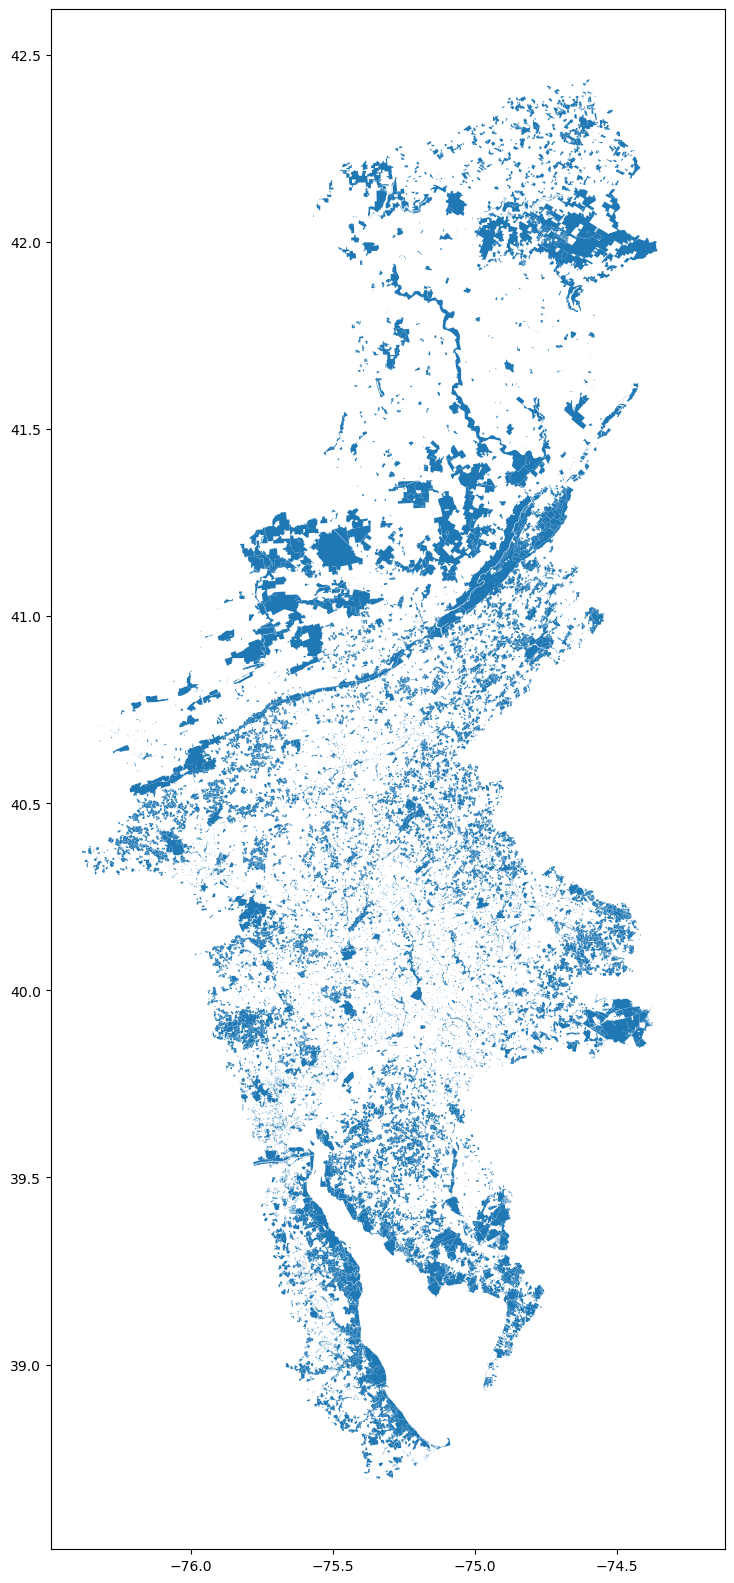

In [14]:
plt.rcParams["figure.figsize"] = (20,20)
wcpa_gdf.plot()

## Protected Lands from FieldDoc

In [15]:
# Import FieldDoc protected lands 
fielddoc_gdf = gpd.read_parquet(fielddoc_path)

# Add a column to fielddoc_gdf with data source
fielddoc_gdf['data_source'] = 'fielddoc_2022-08-11'
fielddoc_gdf.head(n=1)

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,head_pwr,nat_land,ara_pwr,wet_pwr,dev_land,ag_land,str_bank,geometry,data_source
0,Bartolacci,5301,Delaware River Watershed Protection Fund - For...,5,Natural Lands Trust,Land Protection \n\nShapefile needs to be load...,Conservation easement,2019-01-14T20:29:48.955938Z,2020-12-21T18:28:07.158142Z,26.0,0.0,39.31,25.94,8.59,0.02,0.0,0.43,"POLYGON ((-75.22603 41.12858, -75.22736 41.128...",fielddoc_2022-08-11


In [16]:
fielddoc_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   practice_name  75 non-null     object  
 1   practice_id    75 non-null     int64   
 2   program_name   75 non-null     object  
 3   program_id     75 non-null     int64   
 4   organization   75 non-null     object  
 5   description    26 non-null     object  
 6   practice_type  75 non-null     object  
 7   created_at     75 non-null     object  
 8   modified_at    75 non-null     object  
 9   tot_pwr        75 non-null     float64 
 10  head_pwr       75 non-null     float64 
 11  nat_land       75 non-null     float64 
 12  ara_pwr        75 non-null     float64 
 13  wet_pwr        75 non-null     float64 
 14  dev_land       75 non-null     float64 
 15  ag_land        75 non-null     float64 
 16  str_bank       75 non-null     float64 
 17  geometry       75 non-null   

### Convert Object to Category dtpe

In [17]:
fielddoc_dtypes = {
    'practice_name': 'category',
    'program_name': 'category',
    'organization': 'category',
    'practice_type': 'category',
    'data_source': 'category'}

In [18]:
fielddoc_gdf = fielddoc_gdf.astype(fielddoc_dtypes)

### Fix invalid geometries

In [34]:
#Identify any invalid geometries
fielddoc_gdf_invalid = fielddoc_gdf[fielddoc_gdf.is_valid == False]
invalid_ind = fielddoc_gdf_invalid.index.to_list()
fielddoc_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,head_pwr,nat_land,ara_pwr,wet_pwr,dev_land,ag_land,str_bank,geometry,data_source


In [20]:
# Fix invalid geometries
for i in invalid_ind:
    geom = fielddoc_gdf_invalid.loc[i]['geometry']
    valid = make_valid(geom)
    fielddoc_gdf.at[i,'geometry'] = valid

### DRWI Geographies

In [21]:
# Import cluster and focus area geometries
cluster_gdf = gpd.read_parquet(project_path / Path('stage1/data/cluster_df.parquet'))  
focusarea_gdf = gpd.read_parquet(project_path / Path('stage1/data/fa_phase2_df.parquet'))

focusarea_gdf.cluster = focusarea_gdf.cluster.replace('Kirkwood Cohansey Aquifer', 'Kirkwood - Cohansey Aquifer') # update name for consistency with other files 
focusarea_gdf.set_index('name', inplace=True)

base_reach_gdf = gpd.read_parquet(project_path / Path('stage1/data/base_df_reach.parquet'))

## HUC12 geometry

In [22]:
huc12_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc12_0204.parquet'))
huc08_gdf = gpd.read_parquet(project_path / Path('stage2/data_output/huc08_0204.parquet'))

In [23]:
# list of hucs in DRB
huc12_in_drb_df = pd.read_csv(project_path / Path('stage1/mmw_huc12_loads/mmw_drbloads.csv'))
huc08_in_drb_df = pd.read_csv(project_path / Path('stage1/data/comids0204_in_drb.csv'))

In [24]:
hucs12_in_drb_list = huc12_in_drb_df['huc12'].to_list()

In [25]:
hucs12_in_drb_list = [str(i).zfill(12) for i in hucs12_in_drb_list]

In [26]:
huc08_in_drb_df = huc08_in_drb_df[huc08_in_drb_df['in_drb'] == 't']

In [27]:
hucs08_in_drb_list = huc08_in_drb_df['huc08'].to_list()
hucs08_in_drb_list = [str(i).zfill(8) for i in hucs08_in_drb_list]

### Remove HUCS outside the DRB

In [28]:
huc12_in_drb_gdf = huc12_gdf[huc12_gdf.huc12.isin(hucs12_in_drb_list)]
huc08_in_drb_gdf = huc08_gdf[huc08_gdf.huc08.isin(hucs08_in_drb_list)]

# Reproject coordinate systems
Reproject all geometries to ESRI 102003 to ensure proper computation of areas.

Must use a coordinate system that correpsonds to an equal area projection (such as ESRI 102003)

Using Albers Equal-Area Conic projection to compute areas: 
- https://epsg.io/5070
- http://www.radicalcartography.net/?projectionref

In [29]:
# Check coordinate systems
wcpa_gdf.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [30]:
ea_crs = 'ESRI:102003'

In [31]:
# Check if fielddoc_gdf has a crs
fielddoc_gdf.crs

In [32]:
# No CRS set for the FieldDoc export 
# Set projection of FieldDoc gdf to match the previous FieldDoc export CRS BEFORE converting to ESRI 102003 
fielddoc_gdf = fielddoc_gdf.set_crs(epsg=4326, inplace=True,allow_override=True)
fielddoc_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [33]:
# Project to equal area crs
gdf_list = [wcpa_gdf, fielddoc_gdf, focusarea_gdf, cluster_gdf,
            huc12_in_drb_gdf, huc08_in_drb_gdf, base_reach_gdf]
for item in gdf_list:
    item.to_crs(crs=ea_crs, inplace=True)

C:\Users\clulay\.conda\envs\drwi_pa\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# Compute FieldDoc BMP Areas

In [35]:
fielddoc_gdf['Area_Ac'] = fielddoc_gdf.geometry.area/4046.86

In [36]:
x=sum(fielddoc_gdf['Area_Ac'])
print('Area (ac): ',x)

Area (ac):  26413.850780411285


In [37]:
list(fielddoc_gdf.program_name.unique())

['Delaware River Watershed Protection Fund - Forestland Capital Grants',
 'Delaware River Watershed Protection Fund - Farm Buffer Capital Grants',
 'Delaware River Watershed Protection Fund - Transaction Grants']

In [38]:
fielddoc_gdf.practice_type.unique()

['Conservation easement', 'Fee acquisition']
Categories (2, object): ['Conservation easement', 'Fee acquisition']

In [39]:
fielddoc_gdf['practice_type'] = 'DRWI Protected Land'

# Merge geodataframes

## Subtract field doc lands from weconservePA to remove any overlap

In [40]:
# Subtract field doc lands from weconservePA lands
dif_gdf = wcpa_gdf.overlay(fielddoc_gdf, how='difference', keep_geom_type=False)

In [41]:
# Check that overlaps were subtracted
orig_area = sum(wcpa_gdf.geometry.area/4046.86)
new_area = sum(dif_gdf.geometry.area/4046.86)
print('Original area (ac): ',orig_area,'\nNew area (ac): ',new_area)

Original area (ac):  2160468.9511226835 
New area (ac):  2145727.6269588885


In [42]:
# Save to parquet
dif_gdf.to_parquet('WCPA_exclude_DRWI.parquet', index=False, engine='pyarrow')

<AxesSubplot: >

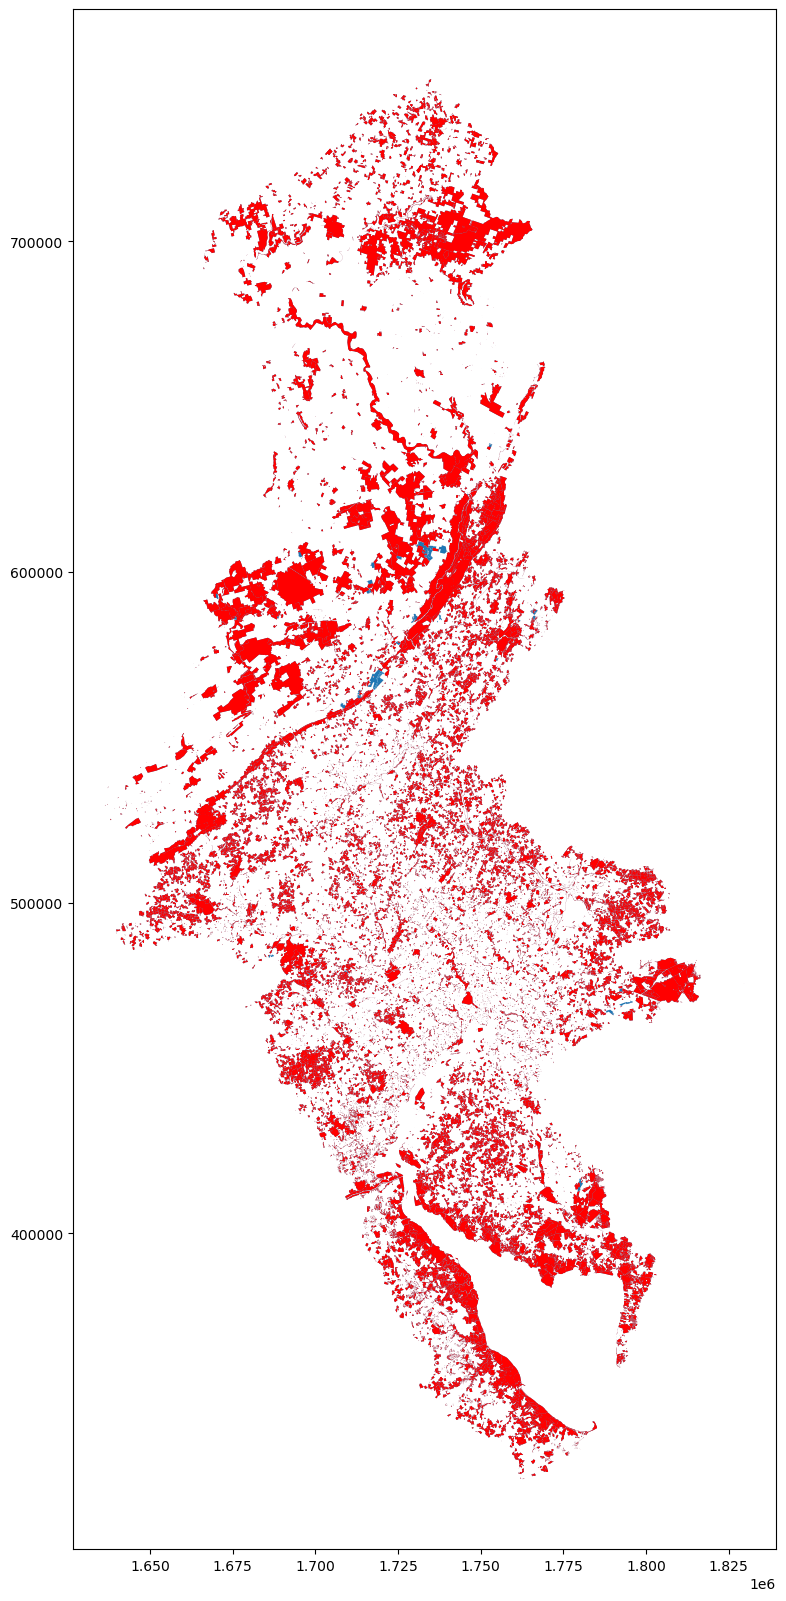

In [43]:
# Plot original weconservePA data against difference gdf
plt.rcParams["figure.figsize"] = (20,20)
fig, ax1 = plt.subplots()
wcpa_gdf.plot(ax=ax1)
cmap = ListedColormap(['red'],name='allred')
dif_gdf.plot(ax=ax1,cmap=cmap)

## Append field doc with weconservePA protected lands

In [44]:
# Clean up column headers to match in merge
dif_gdf.rename(
    columns={
        'sitename': 'practice_name', 
        'purpose': 'description',
        'esmthldr': 'organization', 
        'RECLASS2': 'practice_type'
    }, 
    inplace=True
)

In [45]:
# Append field doc protected lands with pasda protected lands
all_pl_gdf = fielddoc_gdf.append(dif_gdf)
all_pl_gdf.head(n=1)

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,...,WTRSA,State_abb,State,County,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area
0,Bartolacci,5301.0,Delaware River Watershed Protection Fund - For...,5.0,Natural Lands Trust,Land Protection \n\nShapefile needs to be load...,DRWI Protected Land,2019-01-14T20:29:48.955938Z,2020-12-21T18:28:07.158142Z,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Compute final areas

## Address invalid geometries

In [46]:
#Identify any invalid geometries
all_pl_gdf_invalid = all_pl_gdf[all_pl_gdf.is_valid == False]
invalid_ind = all_pl_gdf_invalid.index.to_list()
all_pl_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,...,WTRSA,State_abb,State,County,Municipali,Muni_Type,Muni,MMW,Shape_Leng,Shape_Area


In [47]:
# Fix invalid geometries
all_pl_gdf.reset_index(drop=True, inplace=True)
for i in invalid_ind:
    geom = all_pl_gdf.loc[i]['geometry']
    valid = make_valid(geom)
    all_pl_gdf.at[i,'geometry'] = valid

In [48]:
all_pl_gdf['Final_Area_Ac'] = all_pl_gdf.geometry.area/4046.86
all_pl_gdf[['Area_Ac','Final_Area_Ac']]

,Area_Ac,Final_Area_Ac
0,40.062427,40.062427
1,282.593136,282.593136
2,98.425881,98.425881
3,44.854552,44.854552
4,113.608269,113.608269
...,...,...
22207,121.784450,121.784330
22208,1224.569510,1224.568299
22209,618.064921,618.064310
22210,154.353005,154.352852


In [49]:
all_pl_gdf = all_pl_gdf.reset_index()
all_pl_gdf = all_pl_gdf.to_crs(crs=ea_crs)

fd_area = sum(fielddoc_gdf.geometry.area/4046.86)
all_pl_area = sum(all_pl_gdf.geometry.area/4046.86)

print('WCPA original area (ac): ',orig_area,'\nWCPA New area (ac): ',new_area,'\nFieldDoc area (ac): ',fd_area,'\nAll protected land area (ac): ',all_pl_area)

WCPA original area (ac):  2160468.9511226835 
WCPA New area (ac):  2145727.6269588885 
FieldDoc area (ac):  26413.850780411285 
All protected land area (ac):  2172141.477739299


## Compute Cluster and Focus Areas in correct projection

In [50]:
focusarea_gdf.crs

<Derived Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - CONUS onshore - Alabama; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming.
- bounds: (-124.79, 24.41, -66.91, 49.38)
Coordinate Operation:
- name: USA_Contiguous_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [51]:
cluster_gdf['Area_Ac'] = cluster_gdf.geometry.area/4046.86
focusarea_gdf['Area_Ac'] = focusarea_gdf.geometry.area/4046.86

# Compute % protected for each HUC

In [52]:
# Sq meters to acres conversion factor used in the following calculations
m2_ac_conv = 4046.86

In [53]:
huc12_in_drb_gdf.set_index('huc12', inplace=True)

In [54]:
#Identify any invalid geometries
all_pl_gdf_invalid = fielddoc_gdf[fielddoc_gdf.is_valid == False]
invalid_ind = all_pl_gdf_invalid.index.to_list()
all_pl_gdf_invalid

,practice_name,practice_id,program_name,program_id,organization,description,practice_type,created_at,modified_at,tot_pwr,head_pwr,nat_land,ara_pwr,wet_pwr,dev_land,ag_land,str_bank,geometry,data_source,Area_Ac


In [60]:
huc_protected = {'huc': [], 'huc_ac': [], 'wcpa_ac': [],
                 'fd_ac': [], 'total_perc_protected': []}

n = 1

for huc in huc12_in_drb_gdf.index:
    geom = huc12_in_drb_gdf.loc[[huc]]
    wcpa_in_huc = dif_gdf.clip(geom)
    fd_in_huc = fielddoc_gdf.clip(geom)
    wcpa_in_huc = wcpa_in_huc[wcpa_in_huc['practice_type'] != 'Agricultural Easement']
    
    # Fix fielddoc invalid geometries from clip

    # Calculate protected fraction of total area
    huc_acres = sum(geom.geometry.area/m2_ac_conv)
    wcpa_acres = sum(wcpa_in_huc.geometry.area/m2_ac_conv)
    fd_acres = sum(fd_in_huc.geometry.area/m2_ac_conv)
    protected_percent = 100 * (wcpa_acres + fd_acres) / huc_acres
    
    huc_protected['huc'].append(huc)
    huc_protected['huc_ac'].append(huc_acres)
    huc_protected['wcpa_ac'].append(wcpa_acres)
    huc_protected['fd_ac'].append(fd_acres)
    huc_protected['total_perc_protected'].append(protected_percent)
    
    clear_output()
    print(f'{n/484*100} % complete')
    
    n = n + 1

1.0 % complete


In [61]:
huc_protected_df = pd.DataFrame().from_dict(huc_protected)

In [65]:
huc_protected_df.set_index('huc', inplace=True)

In [71]:
huc12_protected_gdf = huc12_in_drb_gdf.merge(huc_protected_df, left_index=True, right_index=True, how='left')

In [72]:
project_path

WindowsPath('C:/Users/clulay/OneDrive - LimnoTech/Documents/GitHub/pollution-assessment')

In [74]:
huc12_protected_gdf.to_parquet(project_path / Path('stage2/Protected_Lands/huc12_protection.parquet'), index=True, engine='pyarrow')

# Plotting

## Plot distribution of protected lands

### By Cluster

In [45]:
cluster_gdf.index

CategoricalIndex(['Poconos and Kittatinny', 'Middle Schuylkill',
                  'Brandywine and Christina', 'New Jersey Highlands',
                  'Schuylkill Highlands', 'Upstream Suburban Philadelphia',
                  'Kirkwood - Cohansey Aquifer', 'Upper Lehigh'],
                 categories=['Brandywine and Christina', 'Kirkwood - Cohansey Aquifer', 'Middle Schuylkill', 'New Jersey Highlands', 'Poconos and Kittatinny', 'Schuylkill Highlands', 'Upper Lehigh', 'Upstream Suburban Philadelphia'], ordered=False, dtype='category', name='labels')

In [46]:
# Ensure all datasets are in equal-area crs
cluster_gdf = cluster_gdf.to_crs(crs=ea_crs)
focusarea_gdf = focusarea_gdf.to_crs(crs=ea_crs)

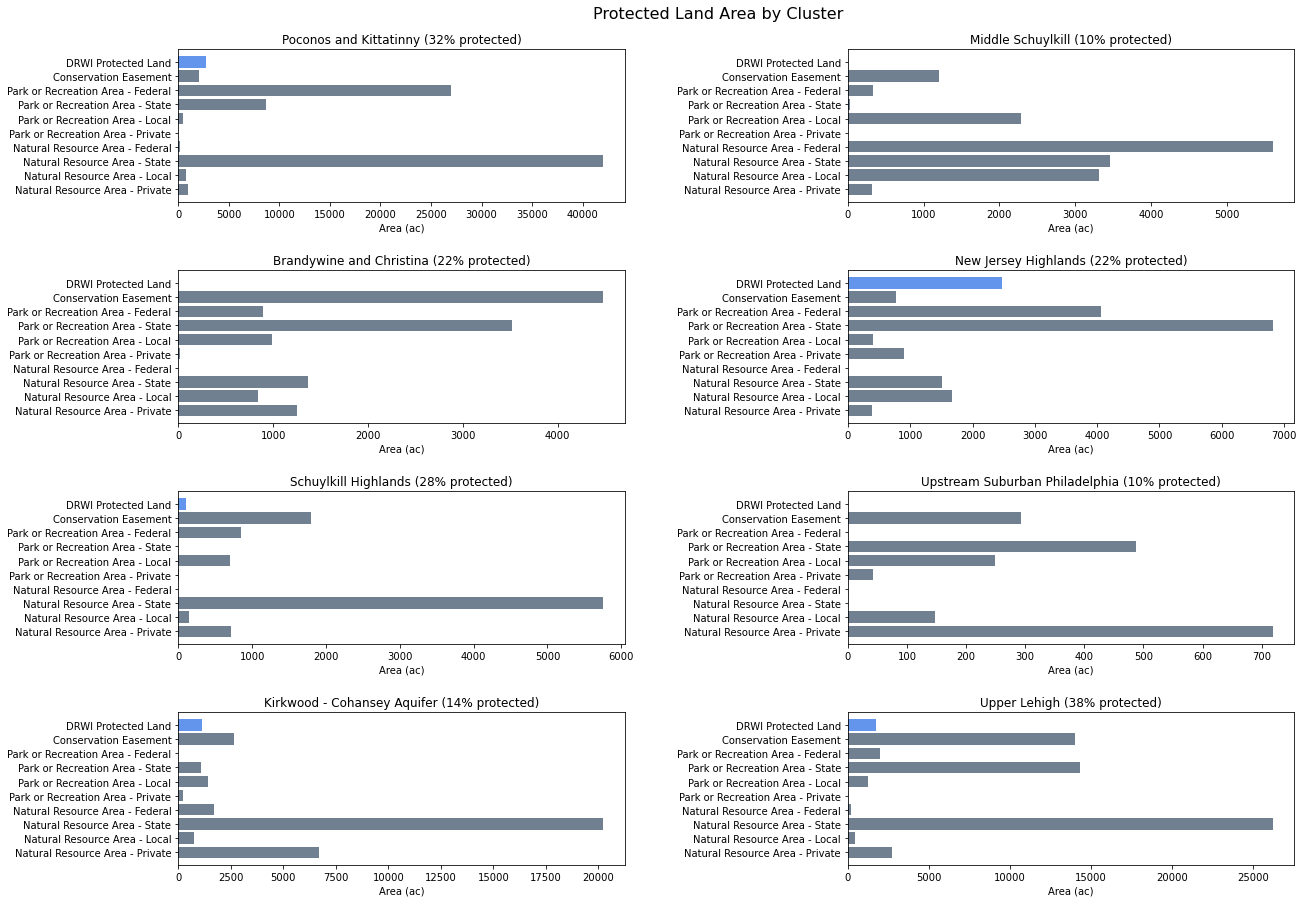

In [47]:
# Plot distribution of protected land area for each cluster
fig, ax = plt.subplots(4,2, figsize=(20,15))
plt.subplots_adjust(hspace=0.45,wspace=0.5)
fig.suptitle('Protected Land Area by Cluster',fontsize=16,y=0.92)
n=0

for cluster in cluster_gdf.index:
    geom = cluster_gdf.loc[[cluster]]
    in_cluster = all_pl_gdf.clip(geom)
    in_cluster = in_cluster[in_cluster['practice_type'] != 'Agricultural Easement']
    n = n+1

    # Calculate protected fraction of total area
    cluster_acres = cluster_gdf.at[cluster,'Area_Ac']
    protected_acres = sum(in_cluster.geometry.area/4046.86)
    in_cluster['Area_in_cluster'] = in_cluster.geometry.area/4046.86
    protected_percent = 100 * protected_acres / cluster_acres
    
    # Create 000 dataframe to set barchart labels
    df = pd.DataFrame({'practice' : ['Natural Resource Area - Private',
                                     'Natural Resource Area - Local',
                                     'Natural Resource Area - State',
                                     'Natural Resource Area - Federal',
                                     'Park or Recreation Area - Private',
                                     'Park or Recreation Area - Local',
                                     'Park or Recreation Area - State',
                                     'Park or Recreation Area - Federal',
                                     'Conservation Easement',
                                     'DRWI Protected Land'],
                       'area' : [0,0,0,0,0,0,0,0,0,0]
                      }
                     )
    
    # Plot
    ax = plt.subplot(4,2,n)

    # Highlight contribution from DRWI
    colors = ['slategrey' if i != 'DRWI Protected Land' else 'cornflowerblue' for i in in_cluster['practice_type']]
    
    plt.barh(df['practice'], width=df['area'])
    plt.barh(in_cluster['practice_type'], width=in_cluster['Area_in_cluster'], color=colors) 
    
    plt.xlabel('Area (ac)')
    plt.title(f'{cluster} ({protected_percent:.0f}% protected)')
    

### By Focus Area

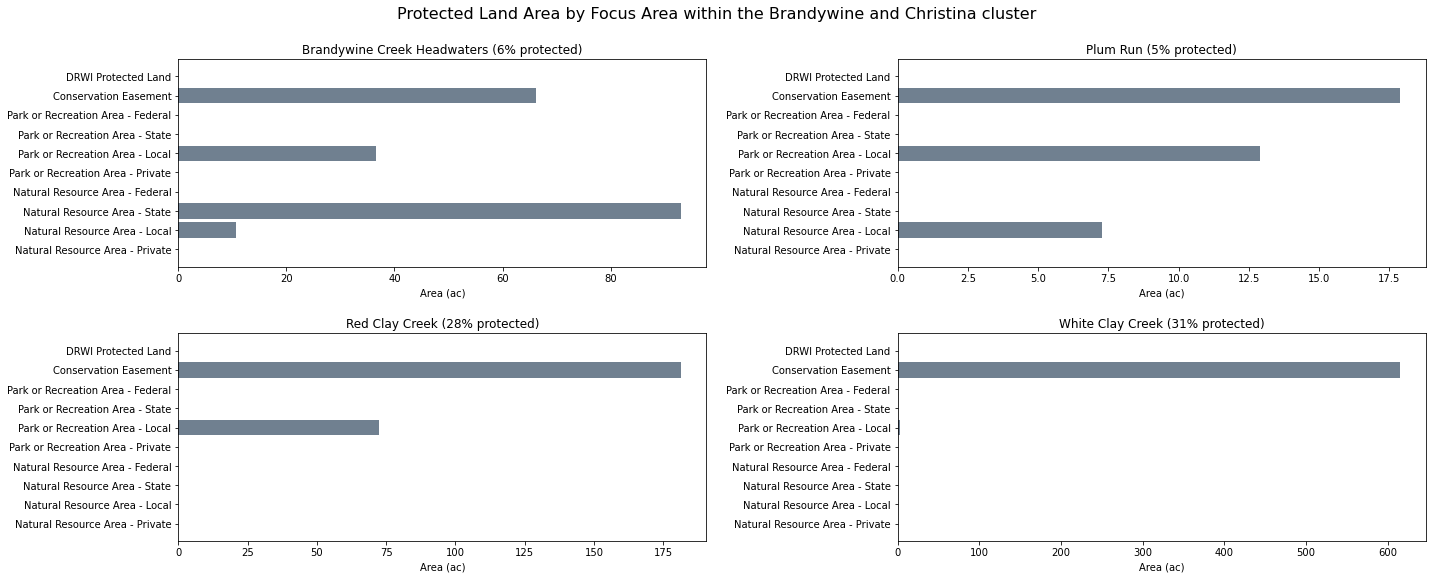

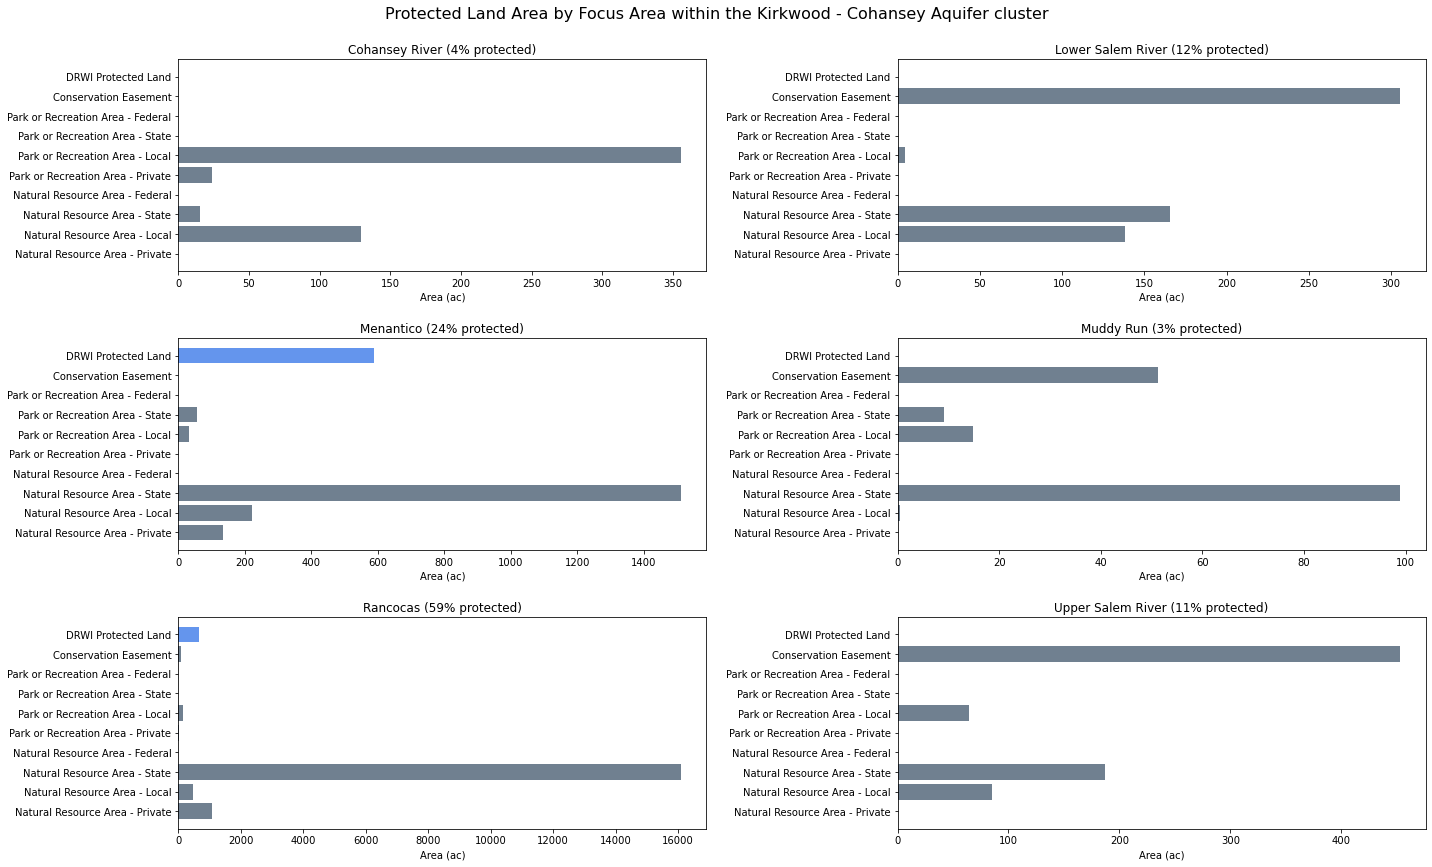

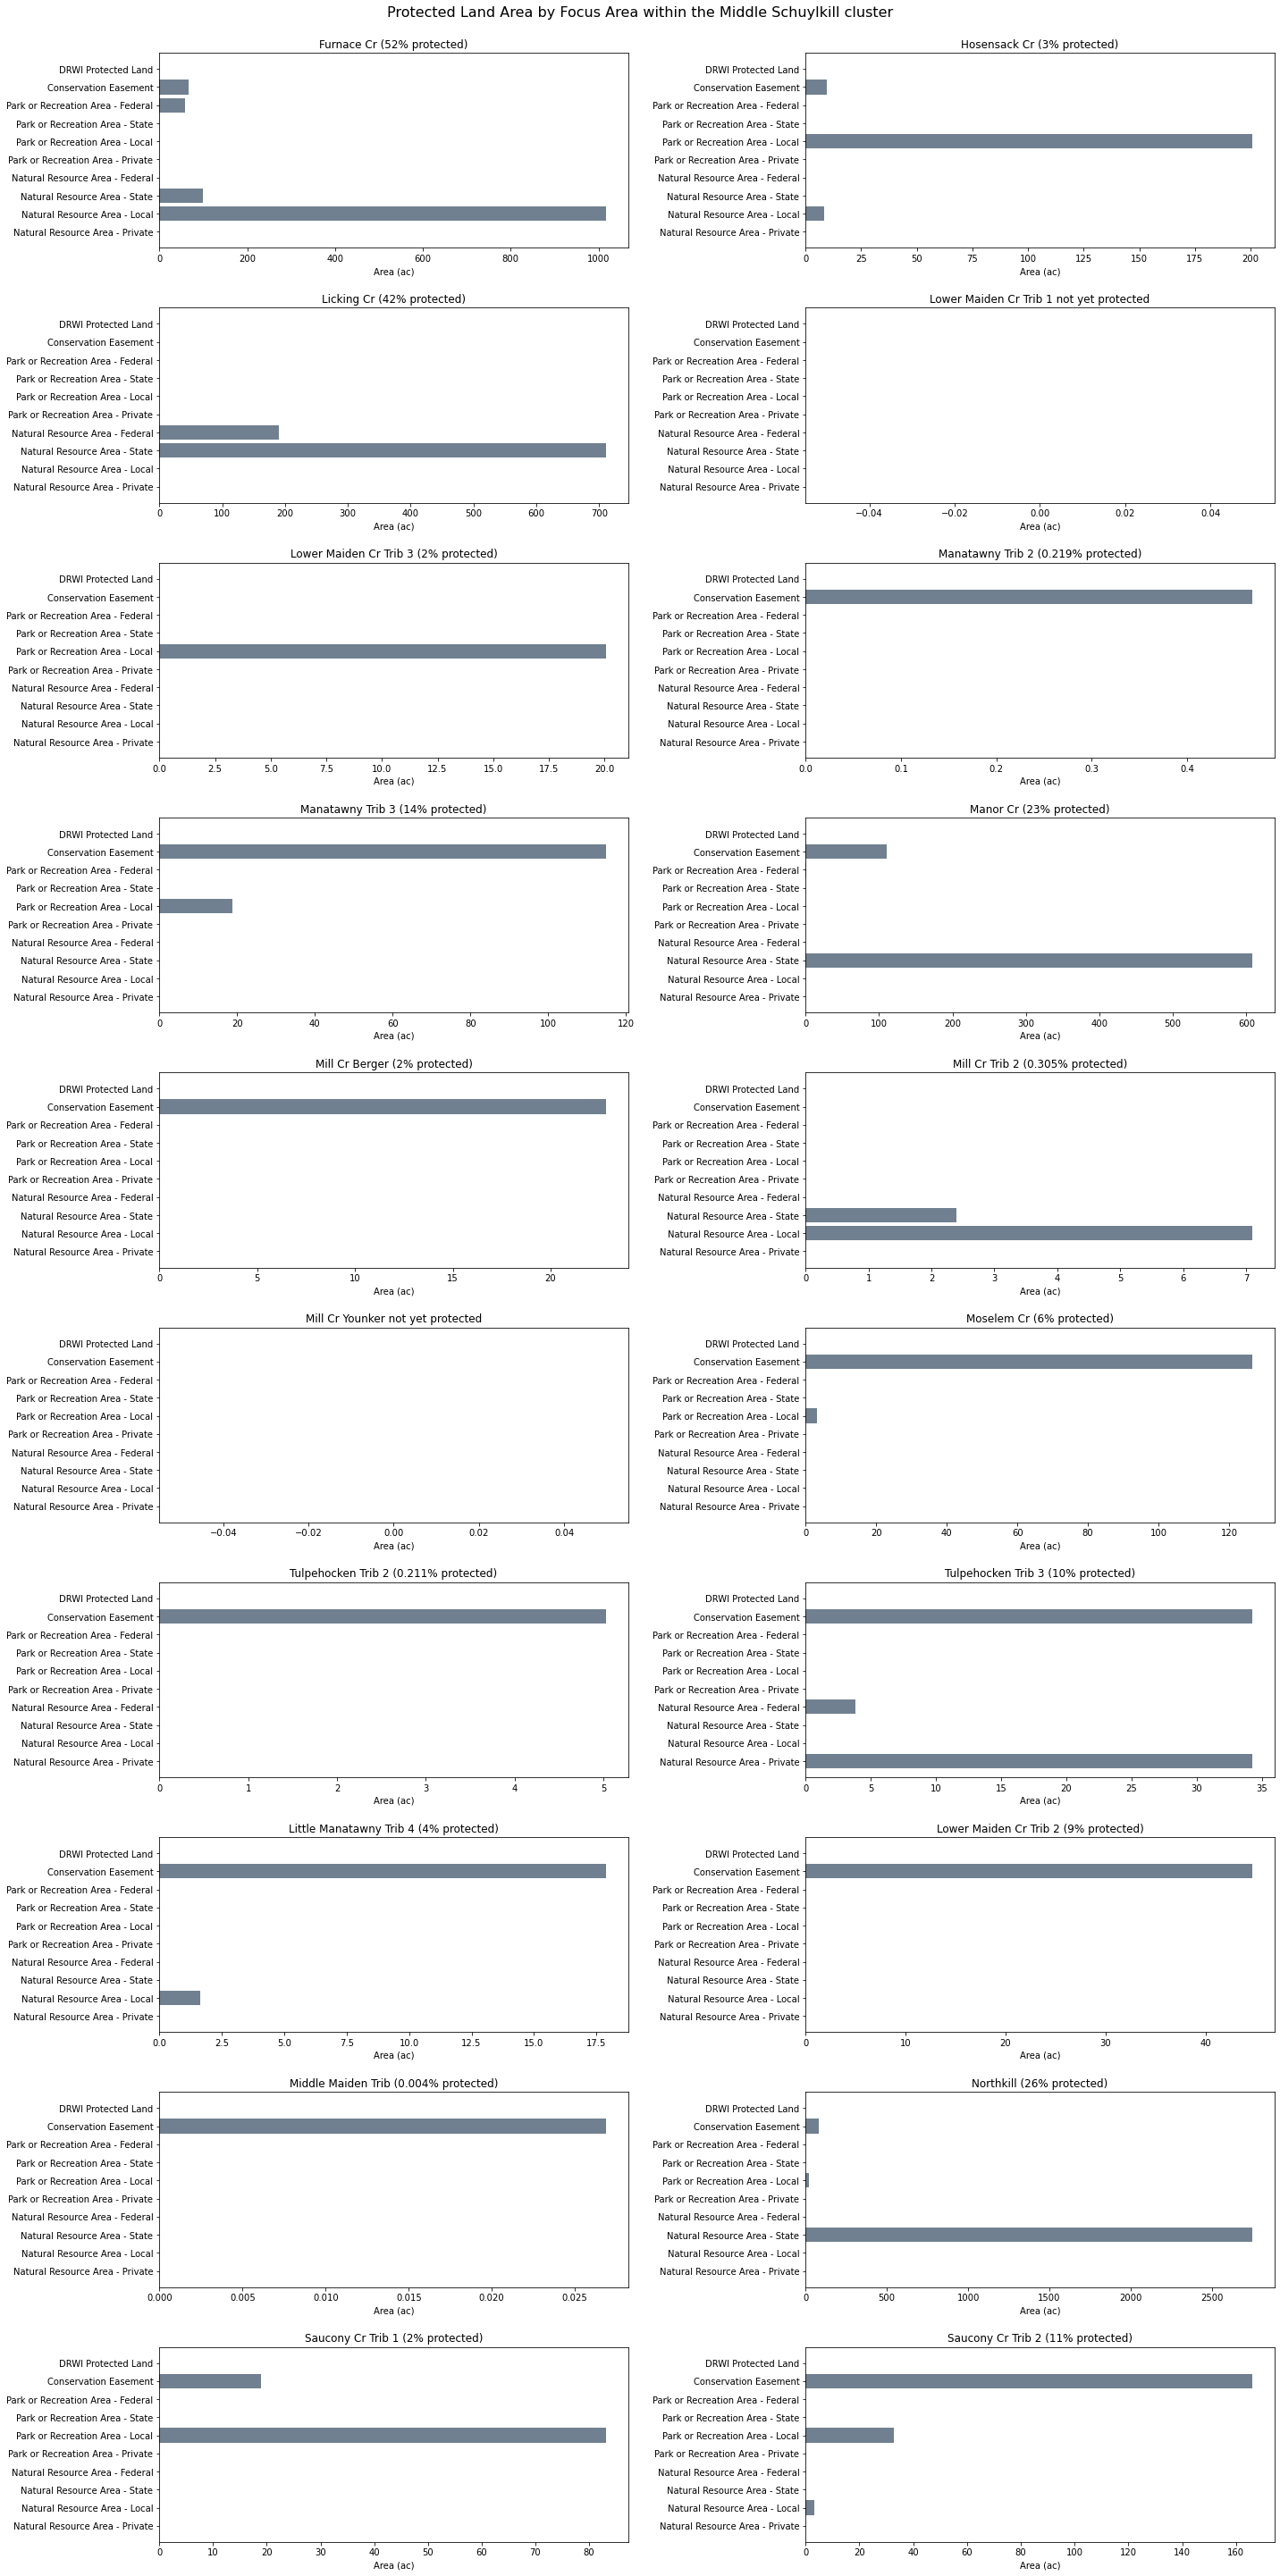

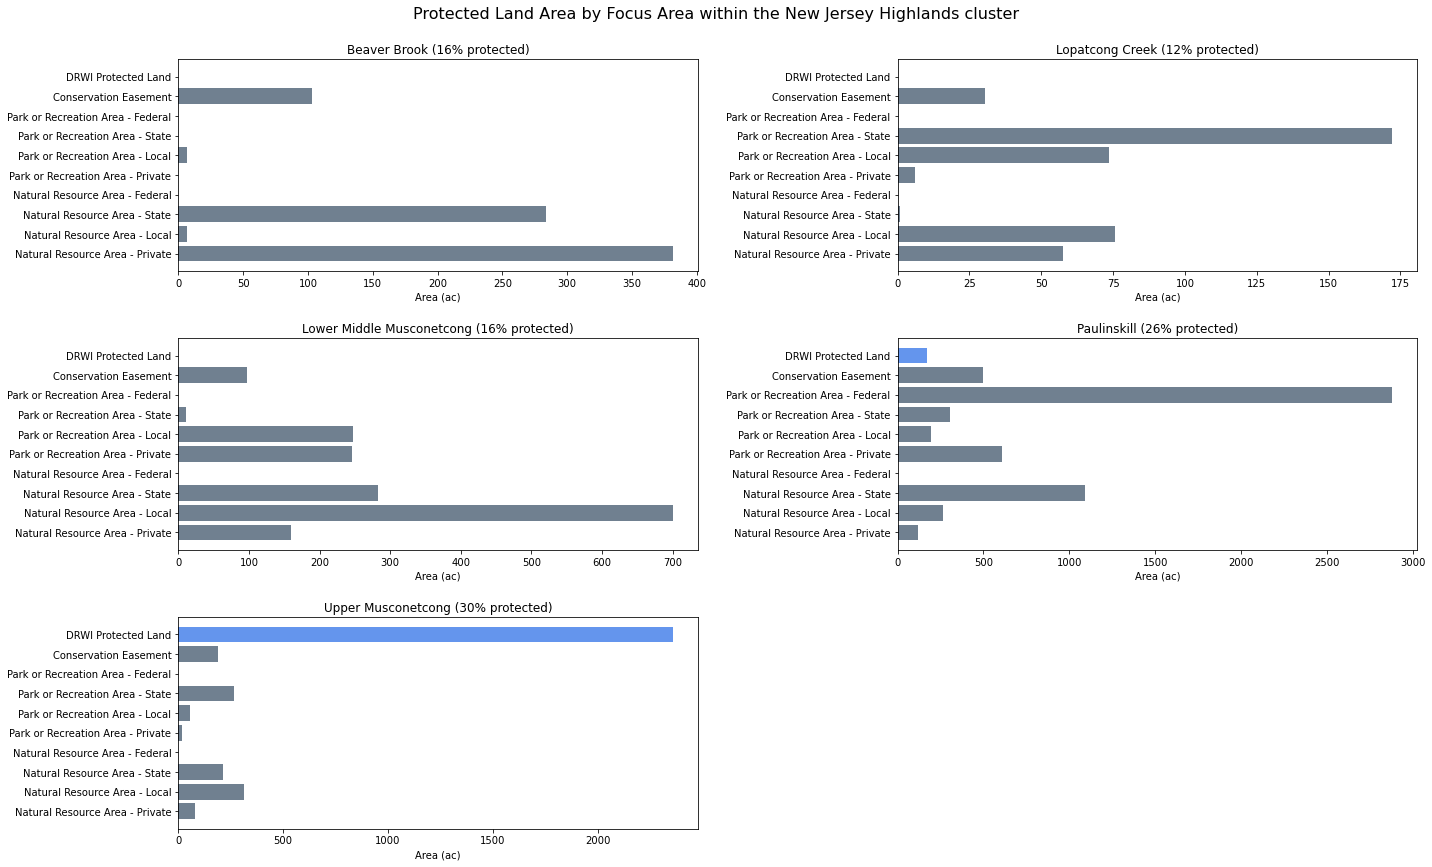

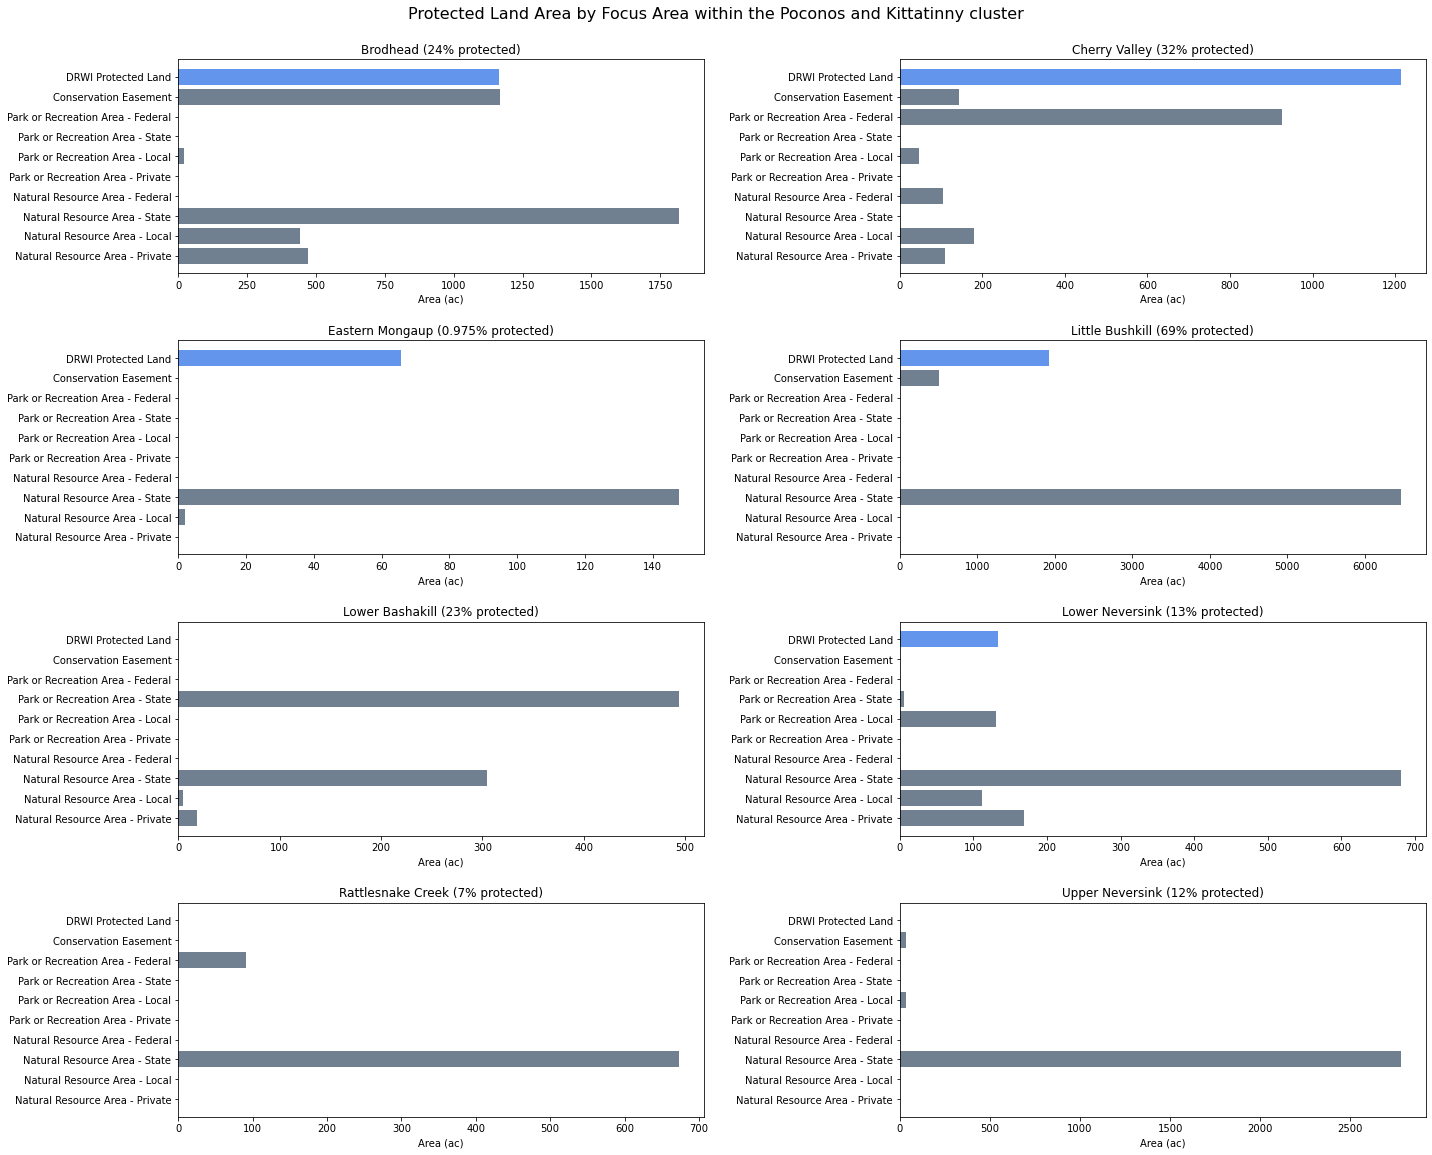

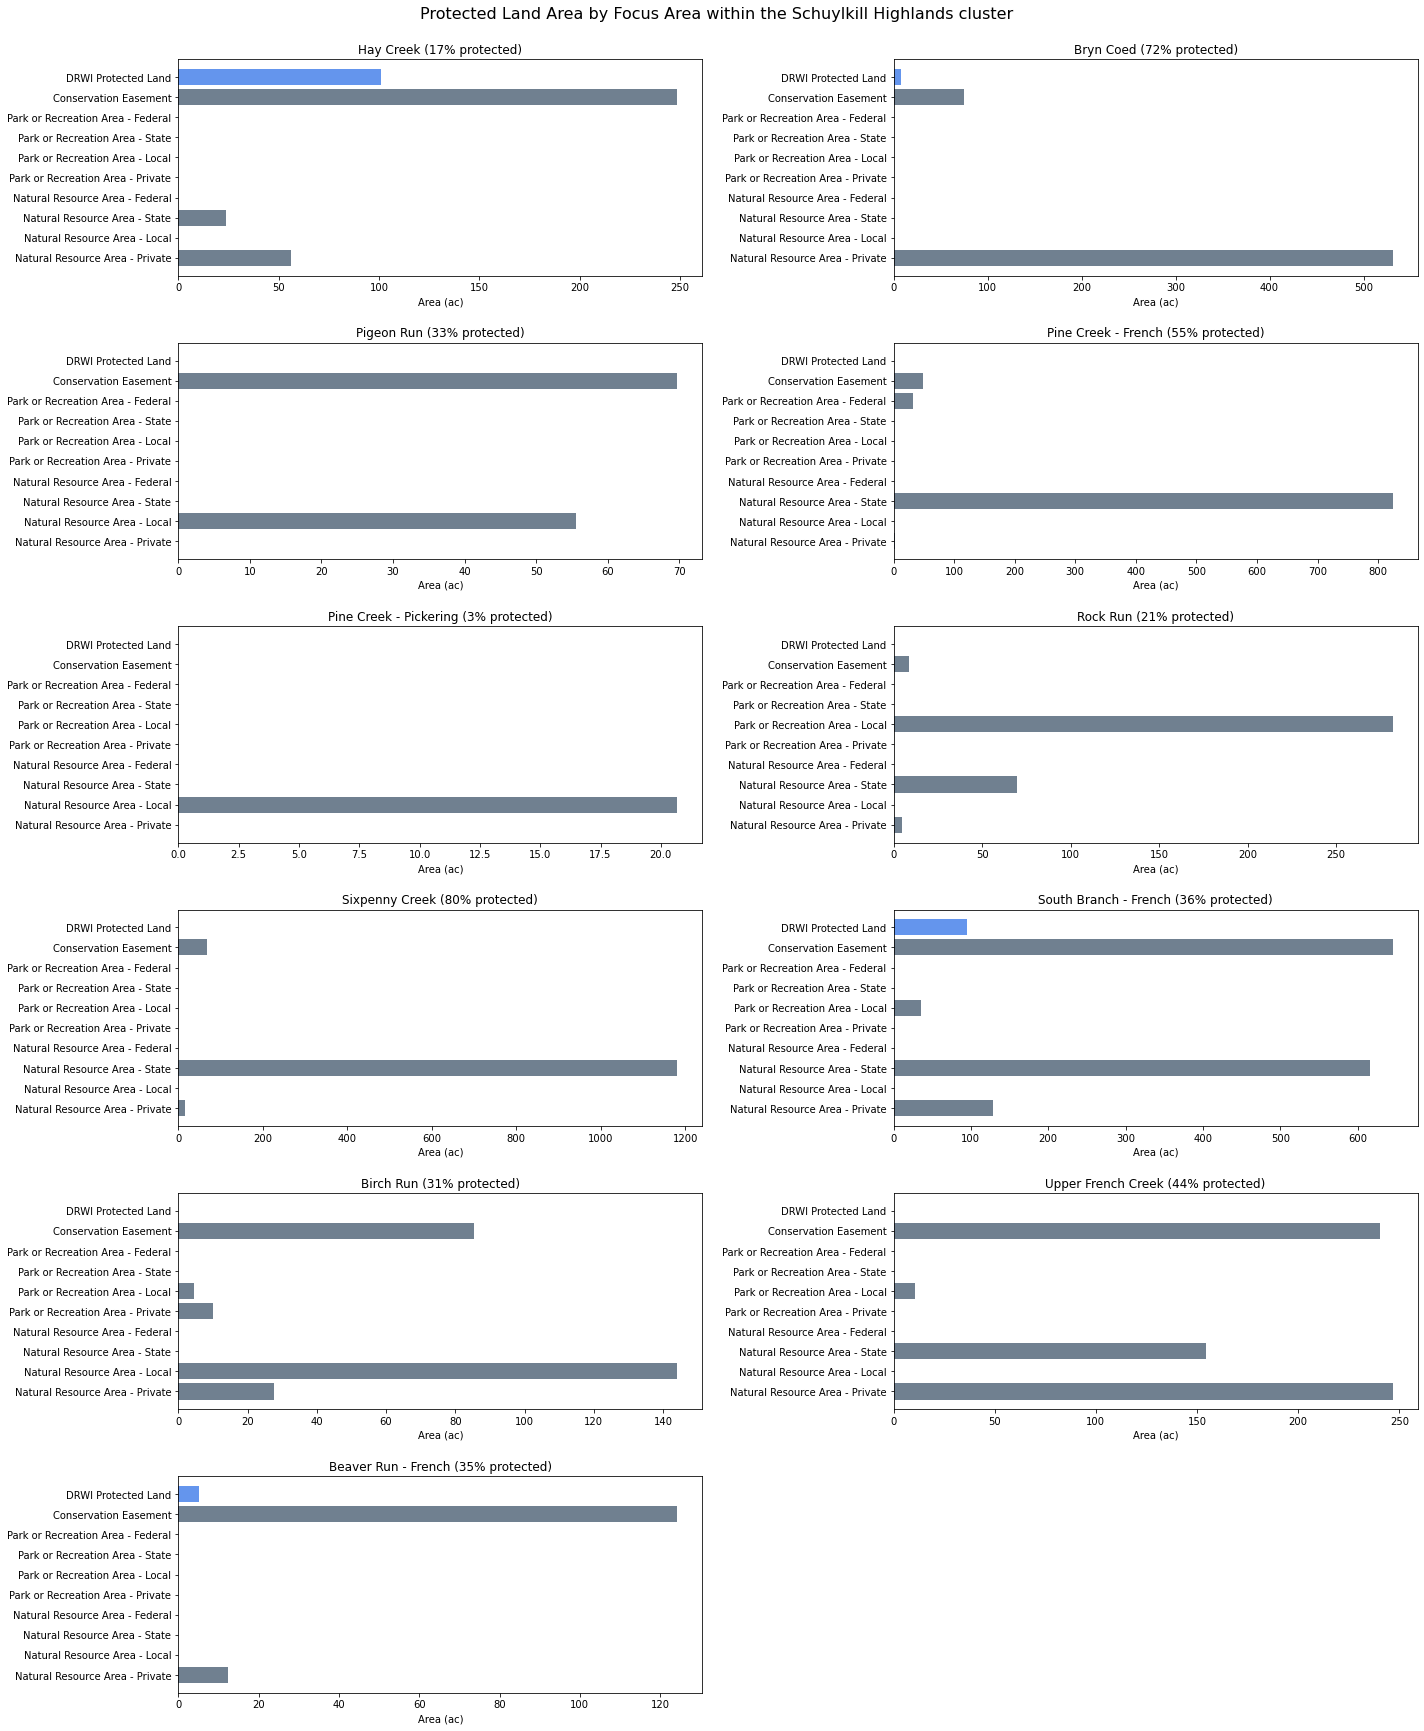

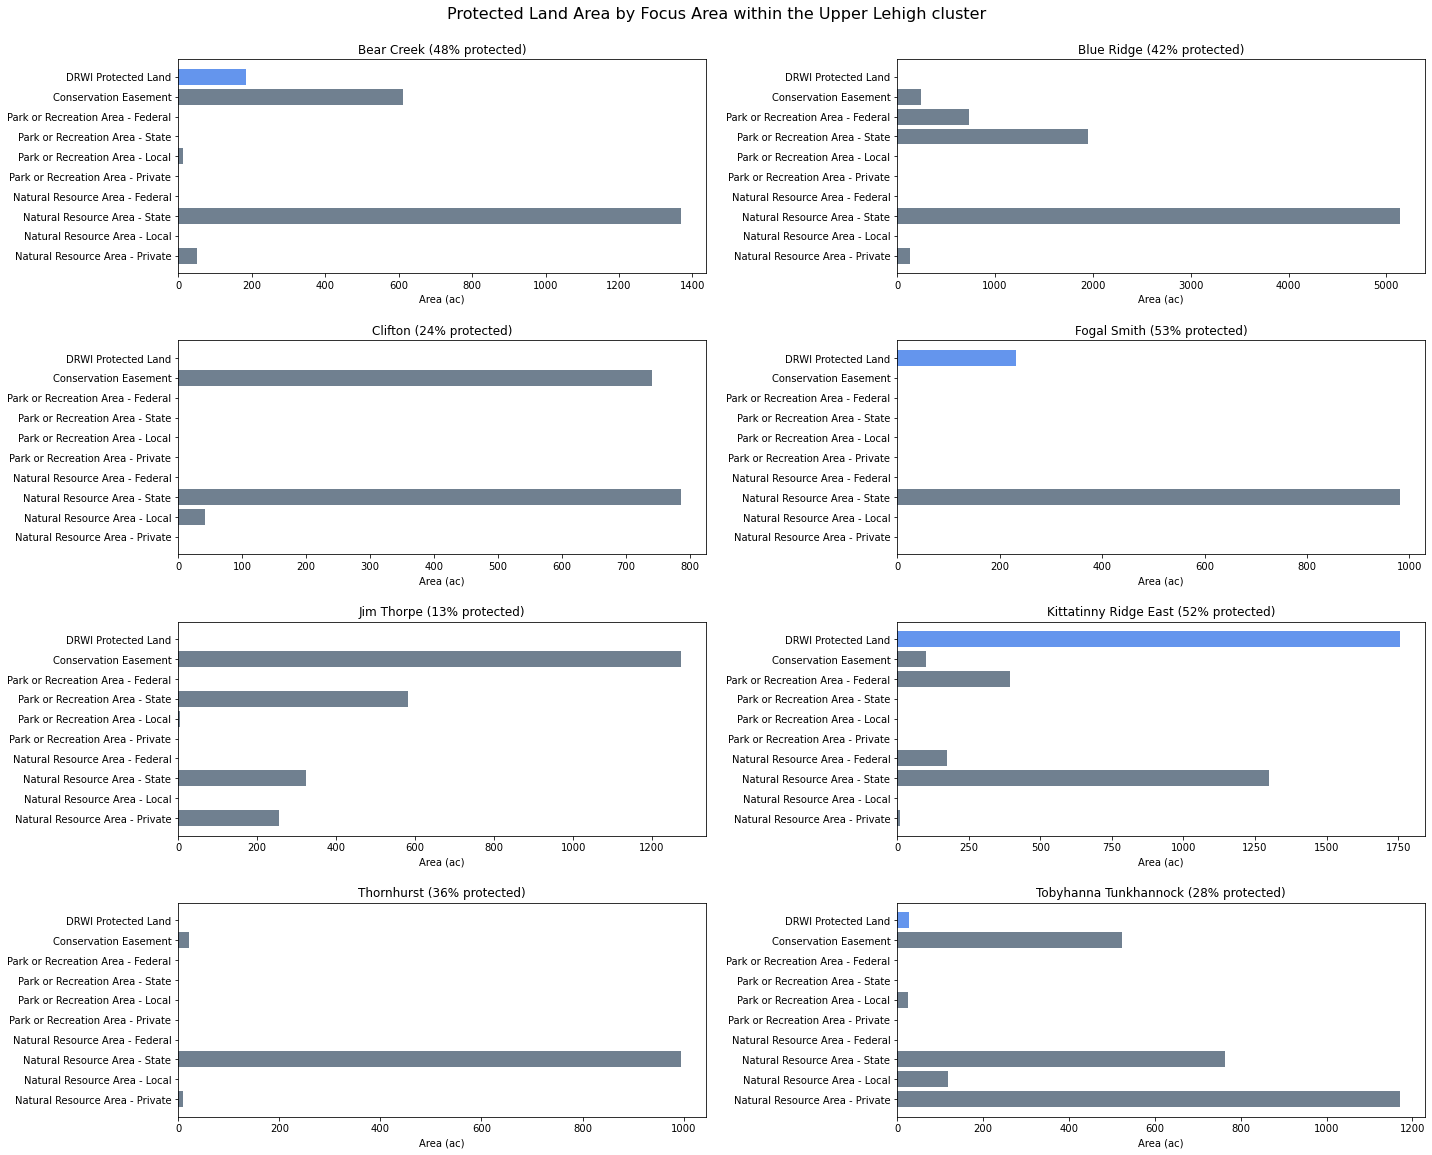

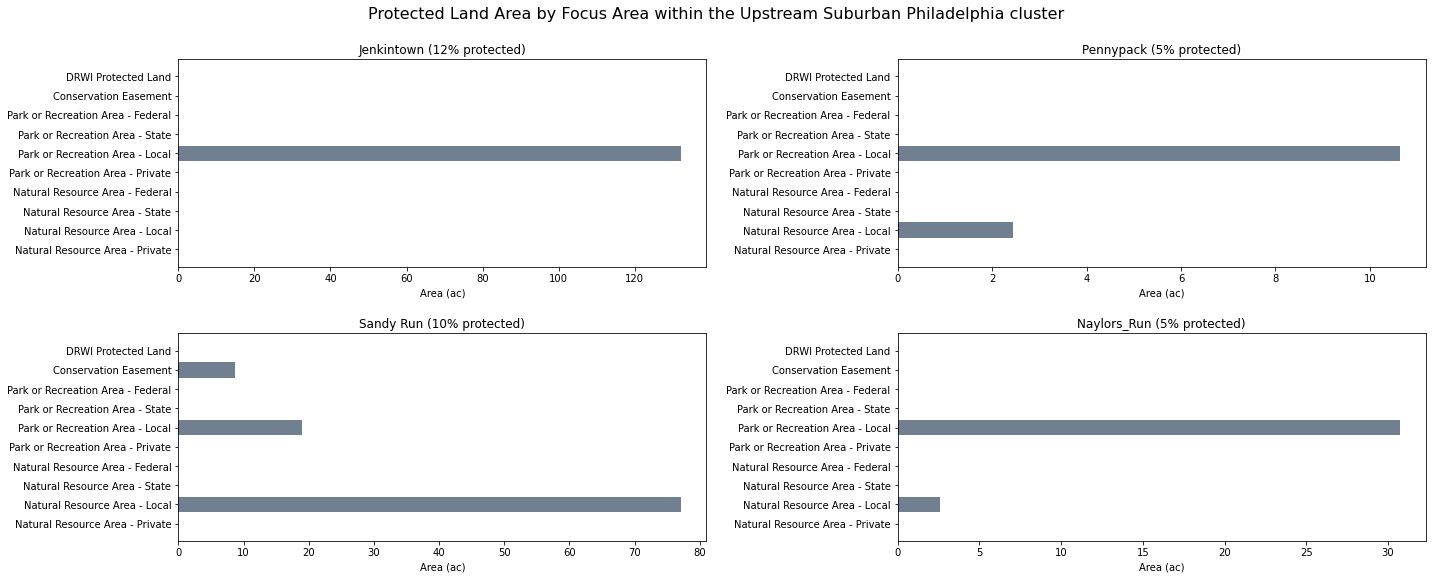

In [48]:
# Get list of clusters 
clusters = focusarea_gdf['cluster'].unique()
clusters = clusters.tolist()
#clusters

for cluster in clusters:
    sgdf = focusarea_gdf[focusarea_gdf['cluster'] == cluster]

    rows = sgdf.shape[0]
    plot_rows = math.ceil(rows/2)
    plot_rows

    fig, ax = plt.subplots(plot_rows,2,figsize=(20,plot_rows*4))
    fig.suptitle(f'Protected Land Area by Focus Area within the {cluster} cluster',fontsize=16,y=1)
    n=0


    for focusarea in sgdf.index:
        geom = sgdf.loc[[focusarea]]
        in_fa = all_pl_gdf.clip(geom)
        in_fa = in_fa[in_fa['practice_type'] != 'Agricultural Easement']

        # Create 000 dataframe to set barchart labels
        df = pd.DataFrame({'practice' : ['Natural Resource Area - Private',
                                         'Natural Resource Area - Local',
                                         'Natural Resource Area - State',
                                         'Natural Resource Area - Federal',
                                         'Park or Recreation Area - Private',
                                         'Park or Recreation Area - Local',
                                         'Park or Recreation Area - State',
                                         'Park or Recreation Area - Federal',
                                         'Conservation Easement',
                                         'DRWI Protected Land'],
                           'area' : [0,0,0,0,0,0,0,0,0,0]
                          }
                         )

        if in_fa.size != 0:
            n = n+1

            # Calculate protected fraction of total area
            fa_acres = sgdf.at[focusarea,'Area_Ac']
            protected_acres = sum(in_fa.geometry.area/4046.86)
            in_fa['Area_in_FA'] = in_fa.geometry.area/4046.86
            protected_percent = 100 * protected_acres / fa_acres

            # Plot
            ax = plt.subplot(plot_rows,2,n) 

            # Highlight contribution from DRWI
            colors = ['slategrey' if i != 'DRWI Protected Land' else 'cornflowerblue' for i in in_fa['practice_type']]

            plt.barh(df['practice'], width=df['area'])
            plt.barh(in_fa['practice_type'], width=in_fa['Area_in_FA'], color=colors)

            plt.xlabel('Area (ac)')

            if 1 > protected_percent > 0:
                plt.title(f'{focusarea} ({protected_percent:.3f}% protected)')

            else: 
                plt.title(f'{focusarea} ({protected_percent:.0f}% protected)')


        if in_fa.size == 0: 
            n = n+1
            ax = plt.subplot(plot_rows,2,n) 

            plt.barh(df['practice'], width=df['area'])
            plt.xlabel('Area (ac)')
            plt.title(f'{focusarea} not yet protected')

    fig.tight_layout(h_pad=2, w_pad=2)
    
    # Remove blank plots
    if (rows % 2) != 0:
        ax_extra = plt.subplot(plot_rows,2,rows+1)
        fig.delaxes(ax_extra)

## Plot zoom map of protected lands

### Functions from stage 1

In [49]:
def FormatAxes(ax, bounds=[-8.56 * 10**6,  -8.17 * 10**6, 4.65* 10**6, 5.26 * 10**6]):
    '''
    Format map axes
    Default is the full extent of the DRB
    '''
    ax.set_xlim(bounds[0], bounds[1])
    ax.set_ylim(bounds[2], bounds[3])
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
def LatLonExtent_FA(fa_list, focusarea_gdf):
    '''
    Get lat and lon extent of a foucs area 
    '''
    mn_x = np.inf
    mx_x = -np.inf
    mn_y = np.inf
    mx_y = -np.inf

    for fa in fa_list:
        values = focusarea_gdf[focusarea_gdf.index==fa].geometry.bounds
        try:
            mn_x = min(mn_x, values.minx[0])
            mx_x = max(mx_x, values.maxx[0])
            mn_y = min(mn_y, values.miny[0])
            mx_y = max(mx_y, values.maxy[0])
        except:
            pass
        
    y_extent = (mx_y - mn_y)
    x_extent = (mx_x - mn_x)


    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    aspect = 1 # (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)


    if base_aspect > aspect:
        lat_max = mx_y + y_cushion
        lat_min = mn_y - y_cushion

        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = mx_x + x_pad
        lon_min = mn_x - x_pad
        
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = mx_x + x_cushion
        lon_min = mn_x - x_cushion 

        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2

        lat_max = mx_y + y_pad
        lat_min = mn_y - y_pad

        h_v = "horizontal"

    else:
        lon_max = mx_x + x_extent
        lon_min = mn_x - x_extent
        lat_max = mx_y + y_extent
        lat_min = mn_y - y_extent

        h_v = "exact"
 
    area = x_extent*y_extent / 1000000000
    
    return lon_max, lon_min, lat_max, lat_min, area, h_v



def LatLonExtent(cluster_name, cluster_gdf):
    '''
    Define latitude and longitude extent of a particular cluster 
    '''

    # initialize list
    lats = []
    lons = []

    # get values
    values = cluster_gdf[cluster_gdf.index==cluster_name].geom.bounds
    y_extent = (values.maxy - values.miny) 
    x_extent = (values.maxx - values.minx)
    y_extent = y_extent[0] 
    x_extent = x_extent[0]
    
    # add 5 percent cushion
    x_cushion = x_extent * 0.05
    y_cushion = y_extent * 0.05

    # maintain aspect ratio 
    # start by finding base aspect ratio of full DRB 
    aspect = (5.26 * 10**6 - 4.65* 10**6)/ (8.56 * 10**6 - 8.17 * 10**6)
    base_aspect = (y_extent + y_cushion) / (x_extent + x_cushion)
    

    # adjust zoomed aspect ratio 
    if base_aspect > aspect:
        lat_max = values.maxy + y_cushion
        lat_min = values.miny - y_cushion
        
        x_tot = (y_extent + 2*y_cushion) / aspect 
        x_pad = (x_tot - x_extent) / 2
        
        lon_max = values.maxx + x_pad
        lon_min = values.minx - x_pad
        h_v = "vertical"

    elif base_aspect < aspect:
        lon_max = values.maxx + x_cushion
        lon_min = values.minx - x_cushion 
        
        y_tot = (x_extent + 2*x_cushion) * aspect
        y_pad = (y_tot - y_extent) / 2
        
        lat_max = values.maxy + y_pad
        lat_min = values.miny - y_pad
        
        h_v = "horizontal"
        
    else:
        lon_max = values.maxx + x_extent
        lon_min = values.minx - x_extent
        lat_max = values.maxy + y_extent
        lat_min = values.miny - y_extent
        
        h_v = "exact"
    
    
    # get area of new plot
    # used to define zoom level for basemap 
    area = x_extent*y_extent / 1000000000
    
    return lon_max[0], lon_min[0], lat_max[0], lat_min[0], area, h_v


### Zoom plotting functions

In [50]:
# Reproject CRS to 3857 for plotting
#wcpa_gdf.to_crs(epsg=3857, inplace=True)
#fielddoc_gdf.to_crs(epsg=3857, inplace=True)
#focusarea_gdf.to_crs(epsg=3857, inplace=True)
#cluster_gdf.to_crs(epsg=3857, inplace=True)

In [51]:
# Zoom to FA
def PL_Zoom_to_FA(pl_gdf, reach_gdf, cl=None, fa=None):
    # Initiate figure
    fig, ax1 = plt.subplots(figsize=(7,7))
    
    # Add protected lands to plot
    pl_gdf.plot(ax=ax1, color='wheat')
    
    # Add focus area to plot
    if fa == None:
        fas_in_cluster = focusarea_gdf[focusarea_gdf.cluster == cl]
    else:
        fas_in_cluster = focusarea_gdf[focusarea_gdf.index.isin(fa)]

    fa_reach = fas_in_cluster.plot(lw=1.25, ax = ax1, facecolor="none", edgecolor="black", zorder=10)

    # Zoom to interest area
    if cl == None:
        print("No cluster entered!")
    else:
        lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent_FA(list(fas_in_cluster.index), focusarea_gdf)
        FormatAxes(ax1, bounds=[lon_min, lon_max, lat_min, lat_max])

    # Add streamreaches to plot
    reach_gdf = reach_gdf.to_crs(pl_gdf.crs.to_string())
    major_streams = reach_gdf[reach_gdf['streamorder'] >= 3].loc[:,('streamorder', 'geom')] 
    rch = major_streams.plot(linewidth=(major_streams['streamorder'] - 1) / 2 , ax=ax1, color='cornflowerblue')
        
    # Add basemap to plot
    if area < 0.05:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=13, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=13, zorder=2, interpolation='sinc')
    elif area < 1:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=11, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=11, zorder=2, interpolation='sinc')
    elif area < 4:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=10, interpolation='sinc')        
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
    else:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=9, interpolation='sinc')        
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')


    plt.show()

In [104]:
# Zoom to cluster
def PL_Zoom_to_Cluster(pl_gdf, reach_gdf, cl=None, fa=None):
    # Initiate figure
    fig, ax1 = plt.subplots(figsize=(10,10))
    
    # Add protected lands to plot
    pl_gdf.plot(ax=ax1, color='wheat')

    # Add cluster outline to plot
    if cl != 'None':
        cl_reach = cluster_gdf[cluster_gdf.index == cl].plot(lw=1, ax=ax1, facecolor="none", edgecolor="black")

    # Add focus area outlines to plot
    if fa != False:
        fas_in_cluster = focusarea_gdf[focusarea_gdf.cluster == cl]

        # fas_in_cluster = focusarea_gdf.loc[fas, :]
        fa_reach = fas_in_cluster.plot(lw=0.7, ax = ax1, facecolor="none", edgecolor="grey")

    # Zoom to interest area 
    lon_max, lon_min, lat_max, lat_min, area, h_v = LatLonExtent(cl, cluster_gdf)
    FormatAxes(ax1, bounds=[lon_min, lon_max, lat_min, lat_max])

    # Add streamreaches to plot
    reach_gdf = reach_gdf.to_crs(pl_gdf.crs.to_string())
    major_streams = reach_gdf[reach_gdf['streamorder'] >= 4].loc[:,('streamorder', 'geom')] 
    #rch = major_streams.plot(linewidth=(major_streams['streamorder']+ 1) % 4, ax=ax1, color='cornflowerblue', zorder=10)

    # Add basemap to plot
    if area < 7:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=10, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=10, zorder=2, interpolation='sinc')
    else:
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron, crs=pl_gdf.crs.to_string(), zoom=9, interpolation='sinc')
        ctx.add_basemap(ax1, source=ctx.providers.CartoDB.PositronOnlyLabels, crs=pl_gdf.crs.to_string(), zoom=9, zorder=2, interpolation='sinc')

    plt.show()


In [109]:
cluster = 'Middle Schuylkill'
geom = cluster_gdf.loc[[cluster]]

wcpa_in_fa = wcpa_gdf.clip(geom)

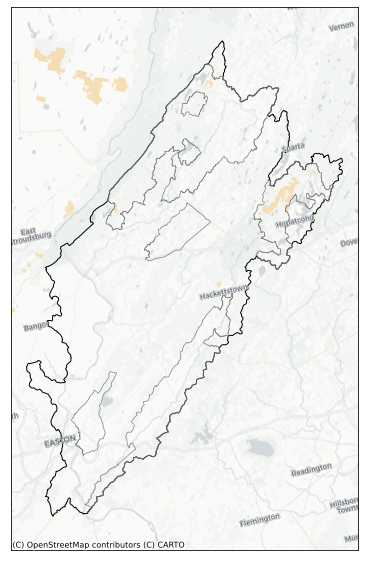

In [112]:
cl = 'New Jersey Highlands'
PL_Zoom_to_Cluster(fielddoc_gdf, base_reach_gdf, cl=cl, fa=True)
#wcpa_gdf.plot(ax=ax1)



In [ ]:
cl = 'Brandywine and Christina'
fa = ['Brandywine Creek Headwaters']
PL_Zoom_to_FA(wcpa_gdf, base_reach_gdf, cl=cl, fa=fa)